In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [25]:
import os
from pathlib import Path

# Diretório onde estão os arquivos
base_dir = "/home/claudio/projetos/case-solar-power-plant/dados/"

# Lista dos arquivos de geração e sensores, com caminhos completos
generation_files = [os.path.join(base_dir, "power_generation_plant_1.csv"),
                    os.path.join(base_dir, "power_generation_plant_2.csv")]

sensor_files = [os.path.join(base_dir, "weather_sensor_plant_1.csv"),
                os.path.join(base_dir, "weather_sensor_plant_2.csv")]

# Lê e concatena todos os arquivos de geração
generation_data = pd.concat([pd.read_csv(file) for file in generation_files], ignore_index=True)

# Lê e concatena todos os arquivos de sensores
sensor_data = pd.concat([pd.read_csv(file) for file in sensor_files], ignore_index=True)

# Contagem de linhas e colunas antes das transformações
print("Dados originais - Geração de Energia:")
print(generation_data.shape)

print("\nDados originais - Sensores Climáticos:")
print(sensor_data.shape)


Dados originais - Geração de Energia:
(136476, 7)

Dados originais - Sensores Climáticos:
(6441, 6)


In [26]:
# Converter a coluna DATE_TIME de volta para datetime após a formatação
generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'], format='mixed', errors='coerce')
sensor_data['DATE_TIME'] = pd.to_datetime(sensor_data['DATE_TIME'], format='mixed', errors='coerce')

# Agrupar dados por hora para facilitar a análise
generation_data['HOUR'] = generation_data['DATE_TIME'].dt.hour
sensor_data['HOUR'] = sensor_data['DATE_TIME'].dt.hour

# Exibir os dados com a nova coluna de hora
print("\nDados com Hora - Geração de Energia:")
print(generation_data[['DATE_TIME', 'HOUR']].head())

print("\nDados com Hora - Sensores Climáticos:")
print(sensor_data[['DATE_TIME', 'HOUR']].head())


Dados com Hora - Geração de Energia:
   DATE_TIME  HOUR
0 2020-05-15     0
1 2020-05-15     0
2 2020-05-15     0
3 2020-05-15     0
4 2020-05-15     0

Dados com Hora - Sensores Climáticos:
            DATE_TIME  HOUR
0 2020-05-15 00:00:00     0
1 2020-05-15 00:15:00     0
2 2020-05-15 00:30:00     0
3 2020-05-15 00:45:00     0
4 2020-05-15 01:00:00     1


In [27]:
# # Função para padronizar e converter a coluna DATE_TIME para timestamp
# def convert_to_timestamp(df, date_column):
#     """
#     Converte a coluna de data para timestamp e garante formato padronizado.
#     """
#     df[date_column] = pd.to_datetime(df[date_column], dayfirst=True, errors='coerce')
#     df[date_column] = df[date_column].dt.strftime('%Y-%m-%d %H:%M:%S')
    
#     return df

# # Aplicar a função de conversão à coluna DATE_TIME
# generation_data = convert_to_timestamp(generation_data, 'DATE_TIME')
# sensor_data = convert_to_timestamp(sensor_data, 'DATE_TIME')

# # Exibir os dados processados para verificação
# print("\nDados processados - Geração de Energia:")
# print(generation_data.head())

# print("\nDados processados - Sensores Climáticos:")
# print(sensor_data.head())

In [28]:
# Verifica se houve alguma conversão falha (por exemplo, valores que não puderam ser convertidos)
print(generation_data['DATE_TIME'].isnull().sum(), "erros no arquivo 1")
print(sensor_data['DATE_TIME'].isnull().sum(), "erros no arquivo 2")

# Exibe uma amostra dos dados para verificar a conversão
print(generation_data[['DATE_TIME']].head())
print(sensor_data[['DATE_TIME']].head())

0 erros no arquivo 1
0 erros no arquivo 2
   DATE_TIME
0 2020-05-15
1 2020-05-15
2 2020-05-15
3 2020-05-15
4 2020-05-15
            DATE_TIME
0 2020-05-15 00:00:00
1 2020-05-15 00:15:00
2 2020-05-15 00:30:00
3 2020-05-15 00:45:00
4 2020-05-15 01:00:00


In [29]:
# Supondo que você já tenha os dados de geração em um DataFrame chamado generation_data

# 1. Agrupar os dados por hora e somar a geração de energia
generation_hourly = generation_data.groupby('HOUR').agg({'AC_POWER': 'sum'}).reset_index()

# 2. Identificar os horários de pico (ex: os 3 maiores valores de AC_POWER)
top_hours = generation_hourly.nlargest(3, 'AC_POWER')

# Exibir as horas com maior geração
print("Horários de pico de geração de energia (3 maiores):")
print(top_hours)

# 3. Verificar períodos de 3 horas consecutivas
generation_hourly['PICK'] = generation_hourly['AC_POWER'] > (top_hours['AC_POWER'].min() * 0.9)  # Ajuste o limite conforme necessário

# Adiciona coluna de grupos
generation_hourly['GROUP'] = (generation_hourly['PICK'] != generation_hourly['PICK'].shift()).cumsum()

# Filtrar grupos de 3 ou mais horas consecutivas
periods_of_interest = generation_hourly[generation_hourly['PICK']].groupby('GROUP').filter(lambda x: len(x) >= 3)

# Exibir os períodos de interesse
print("\nPeríodos de 3 horas consecutivas com alta geração de energia:")
print(periods_of_interest[['HOUR', 'AC_POWER']])


Horários de pico de geração de energia (3 maiores):
    HOUR      AC_POWER
12    12  4.653586e+06
11    11  4.614045e+06
13    13  4.410951e+06

Períodos de 3 horas consecutivas com alta geração de energia:
    HOUR      AC_POWER
10    10  4.320007e+06
11    11  4.614045e+06
12    12  4.653586e+06
13    13  4.410951e+06
14    14  4.011078e+06


In [30]:
# 1. Melhor horário para redirecionamento de energia para baterias
def analyze_peak_hours(generation_df):
    hourly_ac_power = generation_df.groupby('HOUR')['AC_POWER'].sum()
    
    # Identificar o período de maior geração contínua (mínimo 3 horas)
    peak_hours = hourly_ac_power.sort_values(ascending=False).head(3).index.tolist()
    
    return peak_hours

# 2. Eficiência da disposição dos painéis
def analyze_panel_efficiency(generation_df):
    total_dc_power = generation_df['DC_POWER'].sum()
    total_ac_power = generation_df['AC_POWER'].sum()
    
    efficiency = (total_ac_power / total_dc_power) * 100
    return efficiency

# 3. Impacto da temperatura na eficiência
def analyze_temperature_impact(generation_df, weather_df):
    merged_data = pd.merge(generation_df, weather_df, on=['DATE_TIME', 'PLANT_ID'], suffixes=('_gen', '_weather'))

# Correlação entre temperatura ambiente e AC_POWER
    correlation_ambient = merged_data[['AMBIENT_TEMPERATURE', 'AC_POWER']].corr().iloc[0, 1]
    # Correlação entre temperatura do módulo e AC_POWER
    correlation_module = merged_data[['MODULE_TEMPERATURE', 'AC_POWER']].corr().iloc[0, 1]
    
    return correlation_ambient, correlation_module

# 4. Outros insights (Exemplo: impacto da irradiação)
def analyze_irradiation_impact(generation_df, weather_df):
    merged_data = pd.merge(generation_df, weather_df, on=['DATE_TIME', 'PLANT_ID'], suffixes=('_gen', '_weather'))
    
    # Correlação entre irradiação e AC_POWER
    correlation_irradiation = merged_data[['IRRADIATION', 'AC_POWER']].corr().iloc[0, 1]
    
    return correlation_irradiation

# Execução das análises
peak_hours = analyze_peak_hours(generation_data)
efficiency = analyze_panel_efficiency(generation_data)
correlation_ambient, correlation_module = analyze_temperature_impact(generation_data, sensor_data)
correlation_irradiation = analyze_irradiation_impact(generation_data, sensor_data)

# Resultados
print(f"Melhores horários para redirecionamento de energia: {peak_hours}")
print(f"Eficiência dos painéis: {efficiency:.2f}%")
print(f"Correlação entre temperatura ambiente e geração de energia: {correlation_ambient:.2f}")
print(f"Correlação entre temperatura do módulo e geração de energia: {correlation_module:.2f}")
print(f"Correlação entre irradiação e geração de energia: {correlation_irradiation:.2f}")

Melhores horários para redirecionamento de energia: [12, 11, 13]
Eficiência dos painéis: 16.08%
Correlação entre temperatura ambiente e geração de energia: 0.57
Correlação entre temperatura do módulo e geração de energia: 0.84
Correlação entre irradiação e geração de energia: 0.87


### Análise de Períodos de Pico de Geração de Energia

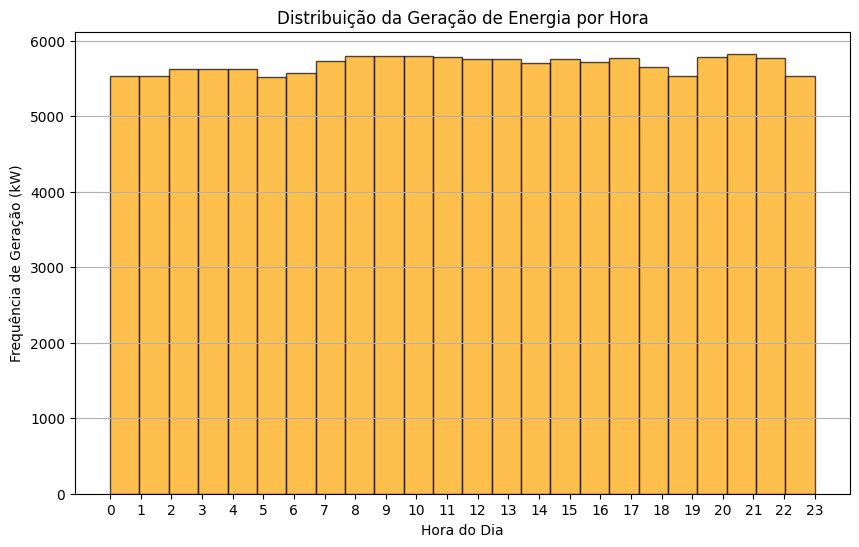

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(generation_data['HOUR'], bins=24, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribuição da Geração de Energia por Hora')
plt.xlabel('Hora do Dia')
plt.ylabel('Frequência de Geração (kW)')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()


### Eficiência da Disposição dos Painéis

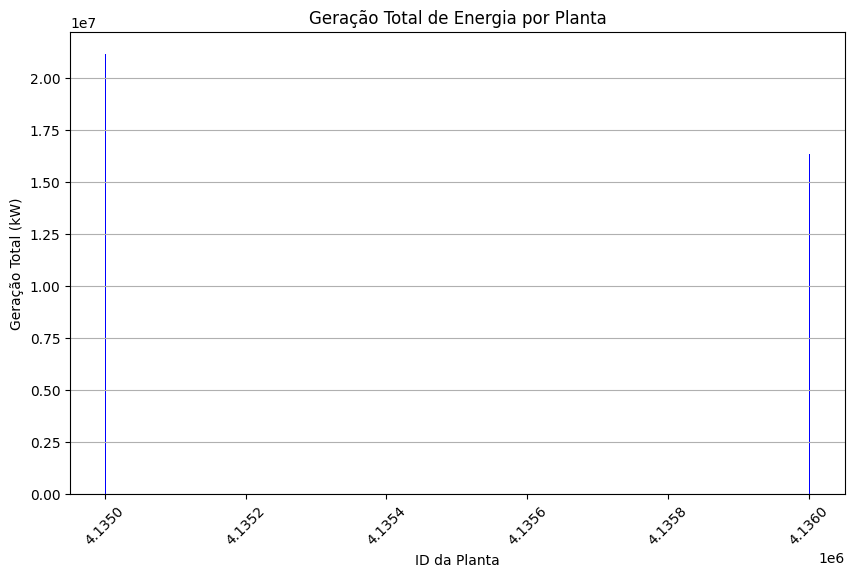

In [32]:
plt.figure(figsize=(10, 6))
generation_summary = generation_data.groupby('PLANT_ID')['AC_POWER'].sum().reset_index()
plt.bar(generation_summary['PLANT_ID'], generation_summary['AC_POWER'], color='blue')
plt.title('Geração Total de Energia por Planta')
plt.xlabel('ID da Planta')
plt.ylabel('Geração Total (kW)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Impacto da Temperatura e Irradiação na Geração de Energia

ValueError: x and y must be the same size

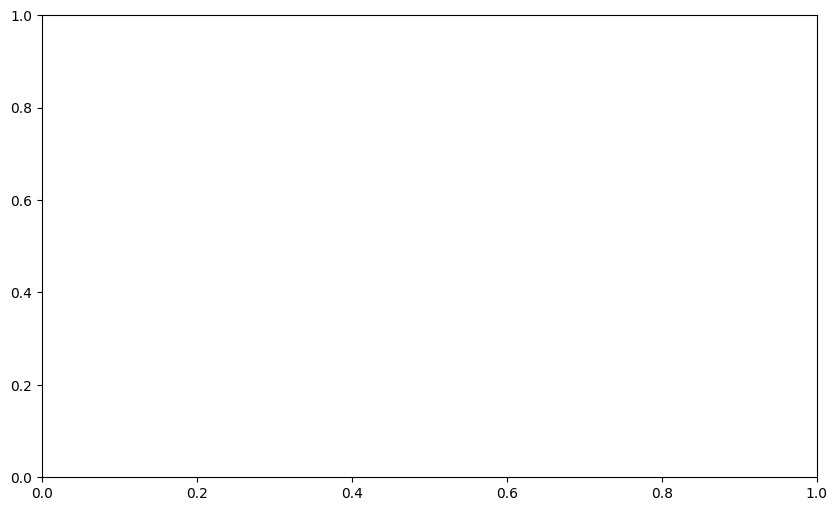

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(sensor_data['MODULE_TEMPERATURE'], generation_data['AC_POWER'], alpha=0.5, color='green')
plt.title('Relação entre Temperatura do Módulo e Geração de Energia')
plt.xlabel('Temperatura do Módulo (°C)')
plt.ylabel('Geração de Energia AC (kW)')
plt.grid()
plt.show()

### Análise de Irradiação vs. Geração de Energia

ValueError: x and y must be the same size

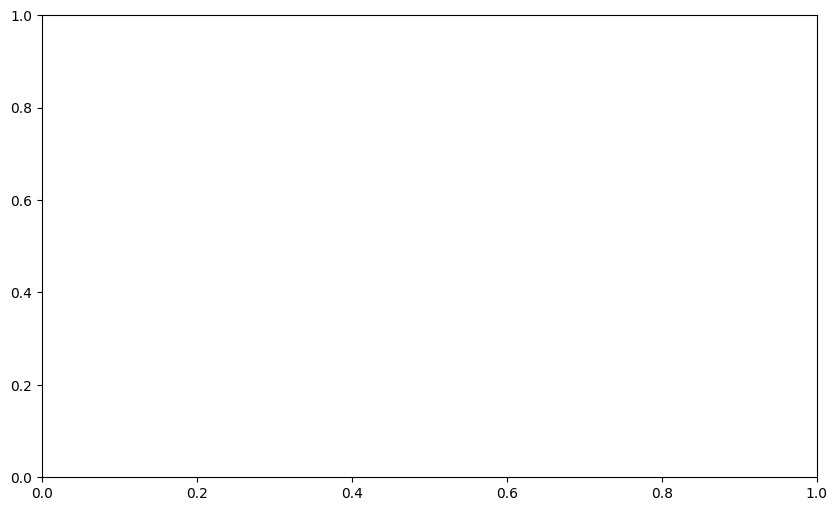

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(sensor_data['IRRADIATION'], generation_data['AC_POWER'], alpha=0.5, color='red')
plt.title('Relação entre Irradiação e Geração de Energia')
plt.xlabel('Irradiação (W/m²)')
plt.ylabel('Geração de Energia AC (kW)')
plt.grid()
plt.show()

### Gráfico: Boxplot da Geração de Energia por Hora

<Figure size 1000x600 with 0 Axes>

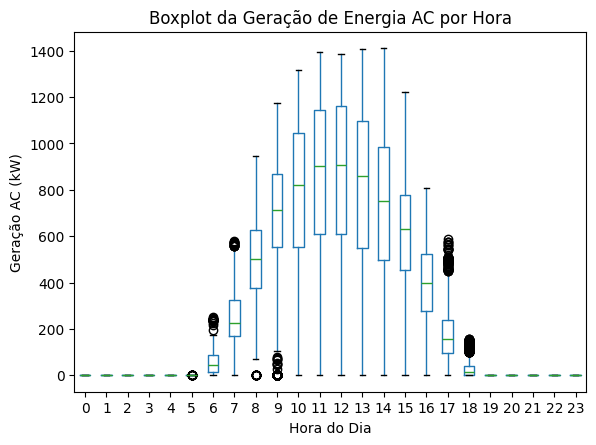

In [35]:
plt.figure(figsize=(10, 6))
generation_data.boxplot(column='AC_POWER', by='HOUR', grid=False)
plt.title('Boxplot da Geração de Energia AC por Hora')
plt.suptitle('')
plt.xlabel('Hora do Dia')
plt.ylabel('Geração AC (kW)')
plt.show()